In [ ]:
import torch
import torchvision

In [ ]:
### parameters
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.1

torch.manual_seed(1)

In [ ]:
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True,
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,),(0.3081,))]))
    

In [ ]:
print("min pixel : {} \nmax Pixel value {}".format(train_set.data.min(), 
train_set.data.max()))
print('Mean pixel val {} \nPixel Values Std: {}'.format(train_set.data.float().mean(),
train_set.data.data.float().std()))
print('scaled Mean pixel val {} \nPixel Values Std: {}'.format(train_set.data.float().mean()/255,
train_set.data.data.float().std()/255))


min pixel : 0 
max Pixel value 255
Mean pixel val 33.31842041015625 
Pixel Values Std: 78.56748962402344
scaled Mean pixel val 0.13066047430038452 
Pixel Values Std: 0.30810779333114624


In [ ]:
test_set = torchvision.datasets.MNIST('./data/', train=False, download=True,
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,),(0.3081,))]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= batch_size_test, shuffle = True)

In [ ]:
train_loader.dataset, test_loader.dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)

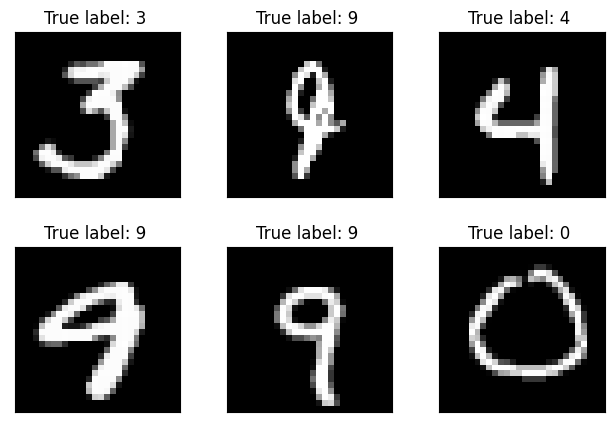

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("True label: {} ".format(example_target[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1  = nn.Linear(320,160) # 320 = 20x4x4
        self.fc2 = nn.Linear(160,10) #num_classes = 10
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x)        



In [ ]:
network = Net()
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=160, bias=True)
  (fc2): Linear(in_features=160, out_features=10, bias=True)
)


In [ ]:
optimizer = optim.SGD(network.parameters(), lr = learning_rate)

In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [ ]:
train_losses = []
test_losses = []

In [ ]:
### train network
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad() ## gradient zero
        ## forward propagation
        output = network(data)
        ## loss 
        loss = loss_func(output, target) ### pred, true
        loss.backward() ## gradiets
        optimizer.step() # updates the parameters
        if batch_idx % 10 == 0:
            print("Train epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f} ".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() ))
            train_losses.append(loss.item())


In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): ### disbales the gradient calculations
        for data, target in test_loader:

            output = network(data)
            test_loss += loss_func(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print("\nTest set: Avg. Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset), 100. *correct/len(test_loader.dataset)
    ))


In [ ]:
test()
for epoch in range(1, n_epochs+1):
    train(epoch)
    test()

/tmp/ipykernel_19316/2301663375.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. Loss: 0.0023, Accuracy: 890/10000 (9%)

Train epoch: 1 [0/60000 (0%)]	 Loss: 2.326693 
Train epoch: 1 [640/60000 (1%)]	 Loss: 2.226762 
Train epoch: 1 [1280/60000 (2%)]	 Loss: 1.962541 
Train epoch: 1 [1920/60000 (3%)]	 Loss: 1.559052 
Train epoch: 1 [2560/60000 (4%)]	 Loss: 1.166387 
Train epoch: 1 [3200/60000 (5%)]	 Loss: 0.958585 
Train epoch: 1 [3840/60000 (6%)]	 Loss: 0.885344 
Train epoch: 1 [4480/60000 (7%)]	 Loss: 1.186169 
Train epoch: 1 [5120/60000 (9%)]	 Loss: 0.791599 
Train epoch: 1 [5760/60000 (10%)]	 Loss: 0.741688 
Train epoch: 1 [6400/60000 (11%)]	 Loss: 0.600322 
Train epoch: 1 [7040/60000 (12%)]	 Loss: 0.922713 
Train epoch: 1 [7680/60000 (13%)]	 Loss: 0.505095 
Train epoch: 1 [8320/60000 (14%)]	 Loss: 0.622586 
Train epoch: 1 [8960/60000 (15%)]	 Loss: 0.381220 
Train epoch: 1 [9600/60000 (16%)]	 Loss: 0.445362 
Train epoch: 1 [10240/60000 (17%)]	 Loss: 0.367402 
Train epoch: 1 [10880/60000 (18%)]	 Loss: 0.398481 
Train epoch: 1 [11520/60000 (19%)]	 L

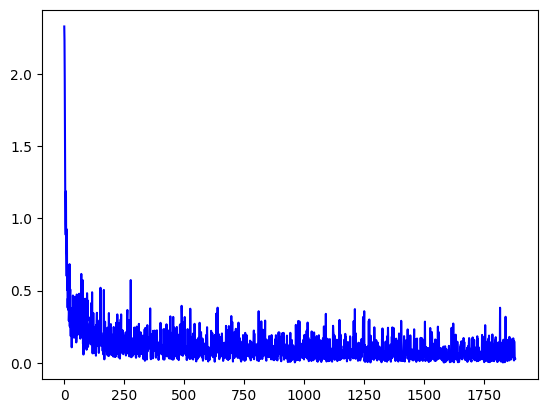

In [ ]:
plt.plot(train_losses,color='blue')
plt.show()

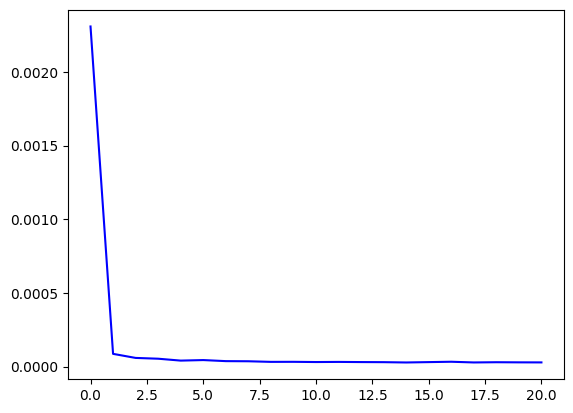

In [ ]:
plt.plot(test_losses, color='blue')
plt.show()

In [ ]:
### predictions
from doctest import OutputChecker


with torch.no_grad():
    Output = network(example_data)

/tmp/ipykernel_19316/2301663375.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


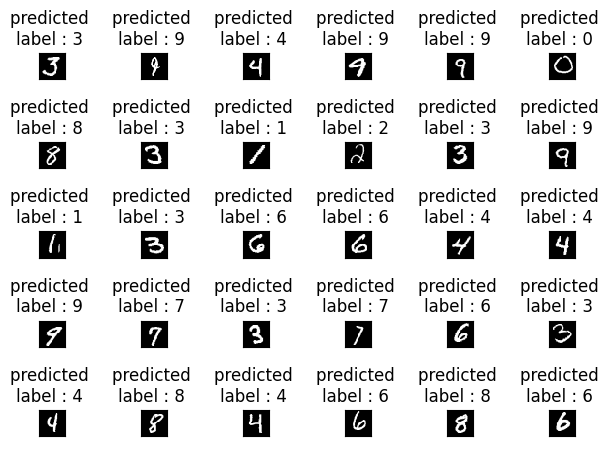

In [ ]:
fig = plt.figure()
for i in range(30):
    plt.subplot(5,6, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray', interpolation='none')
    plt.title("predicted \nlabel : {} ".format(Output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

plt.show()